In [29]:
# === 1. Game State Logic ===
from copy import deepcopy, copy
import pandas as pd
from collections import Counter
import os
import numpy as np
from multiprocessing import Pool
import math
import time
import random
import matplotlib.pyplot as plt
from graphviz import Digraph

# Define the number of rows and columns for the game board
NUM_ROWS = 6
NUM_COLS = 7

class State:
    """
    Represents the state of the Connect Four game, including the game board, 
    available moves, current player, and winner status.
    """
    def __init__(self):
        # Initialize the game board as a 2D list filled with zeros (empty slots)
        self.board = [[0]*NUM_COLS for _ in range(NUM_ROWS)]
        # Track the current height of each column to determine where the next piece will land
        self.column_heights = [NUM_ROWS - 1] * NUM_COLS
        # List of available columns where a move can be made
        self.available_moves = list(range(7))
        # Player 1 starts the game
        self.player = 1
        # -1 indicates that the game is still ongoing, 0 indicates a draw
        self.winner = -1

    def check_line(self, n, player, values):
        """
        Check if a line contains the specified number of pieces (n) for a player.
        Also considers potential winning or strategic lines.
        """
        num_pieces = sum(val == player for val in values)
        if n == 4:
            return num_pieces == 4
        if n == 3:
            return num_pieces == 3 and values.count(0) == 1

    def count_lines(self, n, player):
        """
        Count the number of lines with n pieces for the specified player.
        Looks for horizontal, vertical, and diagonal lines.
        """
        num_lines = 0
        for row in range(NUM_ROWS):
            for col in range(NUM_COLS):
                # Horizontal
                if col < NUM_COLS - 3 and self.check_line(n, player, [self.board[row][col+i] for i in range(4)]):
                    num_lines += 1
                # Vertical
                if row < NUM_ROWS - 3 and self.check_line(n, player, [self.board[row+i][col] for i in range(4)]):
                    num_lines += 1
                # Diagonal (down-right)
                if row < NUM_ROWS - 3 and col < NUM_COLS - 3 and self.check_line(n, player, [self.board[row+i][col+i] for i in range(4)]):
                    num_lines += 1
                # Diagonal (down-left)
                if row < NUM_ROWS - 3 and col > 2 and self.check_line(n, player, [self.board[row+i][col-i] for i in range(4)]):
                    num_lines += 1
        return num_lines

    def move(self, column):
        """
        Simulate a move in the game by dropping a piece into a specified column.
        Returns a new state with the move applied.
        """
        state_copy = deepcopy(self)
        height = state_copy.column_heights[column]

        # Place the piece at the current available height
        state_copy.board[height][column] = self.player
        if height == 0:
            # Column is now full
            state_copy.available_moves.remove(column)
        else:
            # Decrease available height for this column
            state_copy.column_heights[column] = height - 1
        
        # Update winner status after move
        state_copy.update_winner()
        # Switch player
        state_copy.player = 3 - self.player

        return state_copy

    def update_winner(self):
        """
        Update the winner field based on the current board configuration.
        """
        if self.count_lines(4, 1) > 0:
            self.winner = 1
        elif self.count_lines(4, 2) > 0:
            self.winner = 2
        elif not self.available_moves:
            self.winner = 0  # draw

def column_features(state: State, col: int):
    """
    Features for dropping in column `col` from `state`:
      f0 = immediate win (1) or not (0)
      f1 = blocks opponent’s immediate win (1) or not (0)
      f2 = you get exactly 3 in a row (1) or not (0)
      f3 = opponent would get 3 in a row next if you DON’T play here
      f4 = is center column? (1 if col==3 else 0)
    """
    # simulate your move
    s2 = deepcopy(state).move(col)
    # immediate win?
    f0 = 1 if s2.winner == state.player else 0

    # blocks opponent win?
    f1 = 0
    if f0 == 0:  # no need if you already win
        for c2 in s2.available_moves:
            if s2.move(c2).winner == (3 - state.player):
                f1 = 1
                break

    # your 3-in-a-row count after playing
    f2 = 1 if state.count_lines(3, state.player) < s2.count_lines(3, state.player) else 0

    # opponent threat if you don’t play here
    f3 = 0
    # simulate opponent turn on original state
    for c2 in state.available_moves:
        if deepcopy(state).move(c2).winner == (3 - state.player):
            f3 = 1
            break

    # center bias
    f4 = 1 if col == NUM_COLS // 2 else 0

    return [f0, f1, f2, f3, f4]

def build_feature_dataset(match_data):
    """
    Given match logs (states and chosen moves), create a dataset of features and labels
    to train decision trees. Each record contains feature vectors for all 7 columns.
    """
    rows = []
    # for each logged (state, move) record
    for idx, rec in match_data.iterrows():
        # reconstruct state.board, state.player from rec['cell_0'..'cell_41'], rec['player']
        state = State()
        flat = [rec[f'cell_{i}'] for i in range(42)]
        for i, val in enumerate(flat):
            r, c = divmod(i, NUM_COLS)
            state.board[r][c] = val
        state.player = rec['player']
        # compute features for each legal move
        feats = []
        for col in state.available_moves:
            feats += column_features(state, col)
        # label is which index among available_moves was chosen
        label = state.available_moves.index(rec['mtcarlomove'])
        rows.append((feats, label))
    
    # Pad each row to have a consistent length (5 features * 7 columns)
    X, y = [], []
    for rec in rows:
        feat_vec, lbl = rec
        # pad to length 5*7
        if len(feat_vec) < 5*7:
            feat_vec += [0] * (5*7 - len(feat_vec))
        X.append(feat_vec)
        y.append(lbl)
    
    return pd.DataFrame(X, columns=[f'f{i}' for i in range(5*7)]), pd.Series(y)



In [30]:
# === 2. Game Interface ===

def display_board(board):
    """
    Displays the board in a formatted format on the terminal.
    X represents player 1, O represents player 2, and blank spaces are empty positions.
    """
    print("\n  1 2 3 4 5 6 7")
    print(" ---------------")
    for row in board:
        print("|", end="")
        for cell in row:
            print(" ".join("X" if cell == 1 else "O" if cell == 2 else " "), end="|")
        print()
    print(" ---------------")

def print_welcome():
    """
    Prints the game's main menu with available options.
    """
    print("\n===== CONNECT 4 =====")
    print("1. Player vs Player")
    print("2. Player vs Computer")
    print("3. Computer vs Computer")
    print("4. Exit")
    print("====================")

# === Ensemble Training ===

def train_ensemble(match_data, n_trees: int = 7, max_depth: int = 7):
    """
    Trains an ensemble of decision trees using bootstrapping.

    Args:
    match_data (pd.DataFrame): Data with states and moves from previous games.
    n_trees (int): Number of trees to be trained in the ensemble.
    max_depth (int): Maximum depth of each tree.

    Returns:
    List[ID3DecisionTree]: List of trained trees.
    """
    X, y = build_feature_dataset(match_data)
    ensemble = []
    N = len(X)
    for _ in range(n_trees):
        idx = np.random.choice(N, N, replace=True)  # sampling with replacement
        Xt, yt = X.iloc[idx], y.iloc[idx]
        tree = ID3DecisionTree()
        tree.fit(Xt, yt, max_depth=max_depth)
        ensemble.append(tree)
    return ensemble

# === Ensemble Move Executor ===

def make_ensemble_ai(trees_list):
    """
    Creates an AI function based on an ensemble of trees.
    Each tree votes on an index of the `available_moves` list and the majority decides the move.

    Args:
    trees_list (List[ID3DecisionTree]): Ensemble of decision trees.

    Returns:
    Callable[[ConnectFourGame], int]: Function that receives the game and returns the column to play.
    """
    def inner(game: ConnectFourGame):
        st = game.state
        feat = []
        # Generates feature vectors for each possible column
        for col in range(NUM_COLS):
            if col in st.available_moves:
                feat += column_features(st, col)
            else:
                feat += [0]*5  # unavailable column receives zeros
        row = pd.Series(feat, index=[f'f{i}' for i in range(5*NUM_COLS)])

        # Each tree makes a prediction (index in the list of available columns)
        votes = [t.predict_one(row) for t in trees_list]
        try:
            # Majority vote
            best = Counter(votes).most_common(1)[0][0]
            # Ensures that the vote is within the allowed range
            if 0 <= best < len(st.available_moves):
                return st.available_moves[best]
            else:
                raise ValueError(f"Voted move index {best} is invalid for available moves {st.available_moves}")
        except Exception as e:
            # In case of error, choose a random move as fallback
            # print(f"⚠️ Ensemble fallback due to error: {e}")
            return random.choice(st.available_moves)

    return inner


In [31]:
# === 3. Learning from Logs ===

class DecisionNode:
    """
    Represents a node in a decision tree. It can be an internal node (with feature and children)
    or a leaf node (with final label).
    """
    def __init__(self, feature=None, children=None, label=None,
                 n_samples=None, class_counts=None):
        self.feature = feature                          # Feature name
        self.children = children if children else {}    # dict: valor → DecisionNode
        self.label = label                              # class (only if leaf)
        self.n_samples = n_samples                      # n of samples on node
        self.class_counts = class_counts or {}          # distribuition

    def is_leaf(self):
        return self.label is not None   # A node is leaf if it has a label

class ID3DecisionTree:
    """
    Implementation of the ID3 algorithm for decision trees.
    Uses entropy and information gain to build the tree.
    """
    def __init__(self):
        self.tree = None  # Final tree

    def fit(self, X: pd.DataFrame, y: pd.Series, max_depth=None):
        """
        Treina a árvore de decisão com os dados fornecidos.
        
        Args:
    X (pd.DataFrame): Input set (features).
    y (pd.Series): Labels (movements performed).
    max_depth (int): Maximum depth of the tree.
        """
        data = X.copy()
        data['label'] = y  # adds target
        self.tree = self._id3(data, X.columns, depth=0, max_depth=max_depth)

    def _entropy(self, labels):
        """
        Calculates the entropy of a set of labels.
        """
        counts = Counter(labels)
        total = len(labels)
        entropy = 0
        for count in counts.values():
            probability = count / total
            entropy -= probability * math.log2(probability)
        return entropy

    def _information_gain(self, data, feature, target_attribute='label'):
        """
        Calculates the information gain when splitting data based on a feature.
        """
        total_entropy = self._entropy(data[target_attribute])
        values = data[feature].unique()
        weighted_entropy = 0
        for value in values:
            subset = data[data[feature] == value]
            weighted_entropy += (len(subset) / len(data)) * self._entropy(subset[target_attribute])
        return total_entropy - weighted_entropy

    def _id3(self, data, features, depth=0, max_depth=None):
        labels = data['label']
        # statistics of this node
        n_samples = len(labels)
        class_counts = Counter(labels)

        # stopping criteria: pure or no features or depth
        if len(set(labels)) == 1 or len(features) == 0 or (max_depth is not None and depth >= max_depth):
            return DecisionNode(
                label = labels.mode()[0],
                n_samples = n_samples,
                class_counts = class_counts
            )

        # chooses the best feature based on information gain
        gains = [(feat, self._information_gain(data, feat)) for feat in features]
        best_feature, _ = max(gains, key=lambda x: x[1])

        # create annotated internal node
        node = DecisionNode(
            feature = best_feature,
            n_samples = n_samples,
            class_counts = class_counts
        )

        # for each possible value of the feature, generate the child
        for value in data[best_feature].unique():
            subset = data[data[best_feature] == value]
            if subset.empty:
                # fallback: leaf node with mode
                child = DecisionNode(
                    label = labels.mode()[0],
                    n_samples = 0,
                    class_counts = {}
                )
            else:
                rem_feats = features.drop(best_feature)
                child = self._id3(subset, rem_feats, depth+1, max_depth)
            node.children[value] = child

        return node


    def predict_one(self, example, node=None):
        """
        Makes a prediction for a single instance.
        """
        if node is None:
            node = self.tree
        if node.is_leaf():
            return node.label
        feature_value = example[node.feature]
        child = node.children.get(feature_value)
        if child is None:
            return None  # Unknown path
        return self.predict_one(example, child)

    def predict(self, X: pd.DataFrame):
        """
        Makes predictions for a set of instances
        """
        return X.apply(lambda row: self.predict_one(row), axis=1)
    
# Maintain out of class    
def export_id3_to_dot(root: DecisionNode, path: str = "my_tree.dot"):
    """
    Generates a DOT file to be rendered with:
    dot -Tpng my_tree.dot -o my_tree.png
    """
    lines = [
        "digraph Tree {",
        "  node [shape=box, style=filled, fontname=helvetica];"
    ]
    node_defs = []
    edge_defs = []

    def recurse(node, node_id):
        # label
        if node.is_leaf():
            label = f"LEAF\\ncls={node.label}\\nn={node.n_samples}"
        else:
            total = node.n_samples
            parts = [
                f"{cls}:{cnt}({cnt/total*100:.0f}%)"
                for cls, cnt in node.class_counts.items()
            ]
            distrib = "\\n".join(parts)
            label = f"{node.feature}\\nn={total}\\n{distrib}"

        # color
        if node.class_counts:
            maj = max(node.class_counts, key=node.class_counts.get)
            cmap = {1: "lightblue", 2: "lightpink", 3: "lightgreen"}
            fill = cmap.get(maj, "white")
        else:
            fill = "white"

        node_defs.append(
            f'  node{node_id} [label="{label}", fillcolor="{fill}"];'
        )

        next_id = node_id + 1
        for value, child in node.children.items():
            edge_defs.append(
                f'  node{node_id} -> node{next_id} [label="{value}"];'
            )
            next_id = recurse(child, next_id)
        return next_id

    recurse(root, 0)
    lines += node_defs + edge_defs + ["}"]
    with open(path, "w") as f:
        f.write("\n".join(lines))
    print(f"DOT file written to: {path}")



def trainnn(p):
    """
    trains the dstree
    Creates separate ensembles for each player.
    """
    try:
        md = pd.read_csv("match_log.csv")
        md = md[md['mtcarlomove'].notnull()]  # remove unplayed entries
        md.drop_duplicates(subset=[f'cell_{i}' for i in range(42)] + ['player'], inplace=True)
        # separa os dados por jogador
        data1 = md[md['player'] == 1]
        data2 = md[md['player'] == 2]

        if not data1.empty:
            global learned_trees_p1
            learned_trees_p1 = train_ensemble(data1, n_trees=5, max_depth=5)
        if not data2.empty:
            global learned_trees_p2
            learned_trees_p2 = train_ensemble(data2, n_trees=5, max_depth=5)    
        learned_trees = {1: learned_trees_p1, 2: learned_trees_p2}
        return   learned_trees                 
    except FileNotFoundError:
        print("🔸 No match_log.csv found; skipping training.")

# === Saving Logs in CSV file ===

def save_match_log(game_history, winner, file_path="match_log.csv"):
    """
    Saves the history of moves and the result of a game in a CSV file.

    Args:
    game_history (list): List of tuples (state, move made).
    winner (int): Winning player (1, 2 or 0 for a draw).
    file_path (str): Path of the file where to save the data.
    """
    logs = []
    for state, best_move in game_history:
        # Converte o tabuleiro 2D em uma lista plana para armazenamento
        flat_board = sum(state.board, [])
        entry = {f'cell_{i}': val for i, val in enumerate(flat_board)}
        entry['player'] = state.player
        entry['mtcarlomove'] = best_move
        entry['winner'] = winner
        logs.append(entry)

    df = pd.DataFrame(logs)
    header_needed = not os.path.exists(file_path) or os.stat(file_path).st_size == 0
    df.to_csv(file_path, mode='a', header=header_needed, index=False)


In [32]:
# === 4. Game Controller Class ===
class ConnectFourGame:
    """
    Class that manages the flow of the Connect Four game.
    Controls players (AI or human), stores play logs, and runs matches.
    """

    def __init__(self, player_1_ai, player_2_ai):
        # initial state
        self.state = State()
        # Models for eatch player
        self.player_1_ai = player_1_ai
        self.player_2_ai = player_2_ai
        # Move list
        self.match_log = []  # tuple(state, move)

    def record_play(self, state, move):
        """
    Logs a (state, move) pair to the log for later learning.
    Uses deepcopy to preserve the original state.
        """
        self.match_log.append((deepcopy(state), move))

    def save_match_log(self, filename="match_log.csv"):
        """
        Saves the current match log to CSV file.
        """
        if not self.match_log:
            return 
        save_match_log(self.match_log, winner=self.state.winner, file_path=filename)
        self.match_log = []

    def start(self, log_moves: bool = False):
        """
        Starts a match between two players (AI or humans).
        """
        self.state = State()           # Resets the game state
        self.match_log = []            # Resets the match log
        start_time = time.time()

        while self.state.winner == -1:  # While the game is not over
            current_state = deepcopy(self.state)

            # Call the AI ​​function corresponding to the player's turn
            if self.state.player == 1:
                move = self.player_1_ai(self)
            else:
                move = self.player_2_ai(self)

            self.record_play(current_state, move)  # Save the game
            self.state = self.state.move(move)     # Applies the move

            if log_moves:
                display_board(self.state.board)    # Displays the board

        # final messafe
        if log_moves:
            if self.state.winner == 0:
                print("End of game! Draw! %s seconds" % int(time.time() - start_time))
            else:
                print(f"End of game! Player {self.state.winner} wins in %s seconds!" % int(time.time() - start_time))

        self.save_match_log()  # Saves the log on the csv

    def run_n_matches(self, n, max_time=3600, log_moves=True):
        """
        Roda várias partidas consecutivas entre os dois jogadores.
        
        Args:
            n (int): Número de partidas.
            max_time (int): Tempo máximo total (em segundos).
            log_moves (bool): Exibe o tabuleiro a cada jogada.
        """
        start_time = time.time()
        results = [0, 0, 0]  # Índices: 0 = draw, 1 = wins player 1, 2 = wins player 2
        total_games = n

        while n > 0 and time.time() - start_time < max_time:
            n -= 1
            self.start(log_moves)
            results[self.state.winner] += 1  # Updates wins/draws

            # Saves performance logs
            game_number = total_games - n
            with open("performance_log.csv", "a") as f:
                f.write(f"{game_number},{self.state.winner}\n")
            try:
                match_data = pd.read_csv("match_log.csv")
                match_data = match_data[match_data['mtcarlomove'].notnull()]
                match_data.drop_duplicates(subset=[f'cell_{i}' for i in range(42)] + ['player'], inplace=True)
                X = match_data[[f'cell_{i}' for i in range(42)] + ['player']]
                y = match_data['mtcarlomove']
            except FileNotFoundError:
                print("⚠️ match_log.csv not found. AI will only be trained after the first matches.")
                continue
        # Post game stats
        print("\n=== Elapsed time: %s seconds ===" % int(time.time() - start_time))
        player1per = results[1] / total_games * 100
        player2per = results[2] / total_games * 100
        print(f"  Player 1: {results[1]} victories ({player1per:.2f}%)")
        print(f"  Player 2: {results[2]} victories ({player2per:.2f}%)")
        print(f"  Draws: {results[0]}")
        print("===============================")


In [33]:
# === 5. Human & AI Players Moves ===

def human_player_move(game):
    """
    Player move from terminal
    """
    while True:
        try:
            print(f"\nPlayer {game.state.player}'s turn")
            print(f"Available columns: {[col+1 for col in game.state.available_moves]}")
            column = int(input("Enter column number (1-7): ")) - 1  # Converte para índice de 0 a 6
            if column in game.state.available_moves:
                return column  # Retorna a jogada escolhida (índice da coluna)
            else:
                print("Invalid move! Try again.")
        except ValueError:
            print("Please enter a valid number.")

def execute_random_move(game):
    """
    Random ai 
    """
    move = random.choice(game.state.available_moves)
    return move

# === Execução da IA aprendida ===
def execute_learned_move(tree):
    """
    Usess a ID3 decision tree to make a move

    Args:
        tree (ID3DecisionTree): trained tree.

    Returns:
        Callable[[ConnectFourGame], int]: the callable function.
    """
    def inner(game: ConnectFourGame):
        st = game.state
        feat = []

        # adds extra heuristics to for the collums
        for col in range(NUM_COLS):
            if col in st.available_moves:
                feat += column_features(st, col)
            else:
                feat += [0]*5  # invalid collums are filled with 0's

        row = pd.Series(feat, index=[f'f{i}' for i in range(5 * NUM_COLS)])

        try:
            pred = tree.predict_one(row)

            #Guarantee that the move is calid
            if pred is None:
                raise ValueError("Previsão da árvore foi None.")
            if 0 <= pred < len(st.available_moves):
                return st.available_moves[pred]
            else:
                raise ValueError(f"Previsão inválida: {pred} para available_moves: {st.available_moves}")
        except Exception as e:
            return random.choice(st.available_moves)

    return inner


In [50]:
# === 6. Monte Carlo Tree Search ===
def visualize_graphviz(tree, filename="mcts_tree"):
    dot = Digraph(comment='Monte Carlo Tree')

    def add_nodes(dot, node, parent_id=None, node_id_gen=[0]):
        node_id = str(node_id_gen[0])
        
        try:
            board = node.state.board
             #Convertion 
            symbol_map = {0: ".", 1: "X", 2: "O"}  # . = empty, X = player 1, O = player 2

             #Inverts so the orientation is correct
            state_lines = [
                " ".join(symbol_map[cell] for cell in row)
                for row in reversed(board)
            ]
            state_repr = "\\n".join(state_lines)  # Line break
        except Exception as e:
            state_repr = f"Erro ao exibir board: {e}"

        label = f"P{node.player}\\nV:{node.visits}\\nW:{node.wins}\\n{state_repr}"
        dot.node(node_id, label)
        if parent_id is not None:
            dot.edge(parent_id, node_id)
        current_id = node_id
        node_id_gen[0] += 1
        for child in node.children:
            add_nodes(dot, child, current_id, node_id_gen)

    add_nodes(dot, tree.root)
    dot.render(filename, format='png', cleanup=True)
    print(f"📊 Arvore renderizada em {filename}.png")


class MCNode:
    """
    Representa um estado do jogo e armazena estatísticas para as simulações de MCTS.
    """
    def __init__(self, state: State, player: int):
        self.state   = state           # current state
        self.player  = player          # current plyer
        self.wins    = 0               # wins on node
        self.visits  = 0               # visits on node
        self.children = []            # node's children
        self.is_terminal = (state.winner != -1)  # is endgame

    def is_leaf(self):
        return len(self.children) == 0

    def add_child(self, player, n):
        """
        Expands children based on `n`.
        
        Args:
            player (int): current player (1 or 2)
            n (int or str): if 0 == random amount;
                            else number of moves based (max 8 for all moves).
        
        Returns:
            MCNode: A random child.
        """
        if self.is_terminal:
            return None  # Cant expand

        if n == 8:
            for move in self.state.available_moves:
                new_state = self.state.move(move)
                self.children.append(MCNode(new_state, player))
        elif n == 0:
            moves = copy(self.state.available_moves)
            n = random.randint(3, len(moves))
            #print(f"Expandindo {n} filhos.")
            sampled_moves = random.sample(moves, n)  # Choose n unique moves
            for move in sampled_moves:
                new_state = self.state.move(move)
                self.children.append(MCNode(new_state, player))
        else:
            moves = copy(self.state.available_moves)
            n = min(n, len(moves))  # not more tha avaliable moves
            #print(f"Expandindo {n} filhos.")
            sampled_moves = random.sample(moves, n)  #choses n unique moves
            for move in sampled_moves:
                new_state = self.state.move(move)
                self.children.append(MCNode(new_state, player))

        return random.choice(self.children) if self.children else None

    def update_stats(self, value):
        """
        Update win and visits
        """
        if self.player == value: #win
            reward = 1
        elif value == 0:
            reward = 0  # draw
        else:
            reward = 0  # loss
        self.wins += reward
        self.visits += 1

    def update_stats2(self, value):
        """
        Update win and visits
        """
        if self.player == value: #win
            reward = 1
        elif value == 0:
            reward = 0.5  # draw
        else:
            reward = 0  # loss
        self.wins += reward
        self.visits += 1

class MCTree:
    """
    the tree.
    """
    def __init__(self, root):
        self.root = root

    def expand(self, node, player_cur, n):
        return node.add_child(player_cur, n)

def monte_carlo(epochs, tree, c, player, vizualize, nchildren=0, upstats=0):
    """
    Mt carlo.
    """
    for _ in range(epochs):
        visited = []
        player_cur = player
        node = tree.root
        visited.append(node)

        # Seleção: UCT to choose next node
        while not node.is_leaf() and not node.is_terminal:
            node = select(node, node.children, c, player_cur)
            visited.append(node)
            player_cur = 3 - player_cur  # alternates players

        # Expansion
        new_child = tree.expand(node, player_cur, nchildren)
        if new_child is not None and not new_child.is_terminal:
            visited.append(new_child)
            value = roll_out(new_child)  # Simulation
        else:
            value = node.state.winner if node.is_terminal else roll_out(node)

        # Retropropagation to update stats
        if upstats==0:
            for n in visited:
                n.update_stats(value)
        else:
            for n in visited:
                n.update_stats2(value)
    if vizualize:
        visualize_graphviz(tree, "mcts_tree")
    return best_action(tree.root)

def mcts_worker(args):
    """
    Parcial MTC for parallel execution
    """
    (root_state, epochs, c, player) = args
    tree = MCTree(MCNode(deepcopy(root_state), player))
    monte_carlo(epochs, tree, c, player, vizualize=False)
    stats = [(child.wins, child.visits) for child in tree.root.children]
    return stats

def visualize_mcts_root(root, filename="mcts_tree_parallel"):
    """
   Graph for only the root and its children.
    """
    dot = Digraph()
    dot.attr(rankdir='TB')
    dot.attr('node', shape='circle')

    root_label = f"Root\nW/V: {root.wins:.0f}/{root.visits}"
    dot.node("root", root_label)

    for i, child in enumerate(root.children):
        label = f"M{i+1}\nW/V: {child.wins:.0f}/{child.visits}"
        dot.node(f"child_{i}", label)
        dot.edge("root", f"child_{i}")

    dot.render(filename, format='png', cleanup=True)
    print(f"📊 Arvore parallela renderizada em {filename}.png")

def execute_monte_carlo_move_parallel(epochs, c, player, workers=4, vizualize=False):
    """
    Parallel mt carlo wow
    """
    def inner(game: ConnectFourGame):
        root_state = game.state
        root = MCNode(deepcopy(root_state), player)

        # Root pre-expansion
        for mv in root_state.available_moves:
            root.children.append(MCNode(root_state.move(mv), 3 - player))

        per_worker = epochs // workers
        args = [(root_state, per_worker, c, player) for _ in range(workers)]

        # parallel workers
        with Pool(workers) as pool:
            results = pool.map(mcts_worker, args)

        # Statistics agregation
        num_moves = len(root.children)
        agg_wins = [0.0] * num_moves
        agg_visits = [0] * num_moves
        for stats in results:
            for i, (w, v) in enumerate(stats):
                agg_wins[i] += w
                agg_visits[i] += v

        for i in range(num_moves):
            root.children[i].wins = agg_wins[i]
            root.children[i].visits = agg_visits[i]

        # Optional visualization
        if vizualize:
            visualize_mcts_root(root, filename="mcts_root")

        # Best move
        best_idx = max(
            range(num_moves),
            key=lambda i: (agg_wins[i] / agg_visits[i]) if agg_visits[i] > 0 else -1
        )
        best_child = root.children[best_idx]
        for col in range(NUM_COLS):
            if root_state.column_heights[col] != best_child.state.column_heights[col]:
                return col

        return random.choice(root_state.available_moves)  # fallback

    return inner


def select(node, children, c, player):
    """
    UCT selection for next node.
    """

    #optional unused
    #for child in children:
    #    if child.visits == 0:
    #        return child  # Prioritizes unvisited nodes

    best_value = -math.inf
    best_node  = None
    ln_parent  = math.log(node.visits)

    for child in children:
        uct = (child.wins / (child.visits +1)) + c * math.sqrt(ln_parent / (child.visits+1))
        if uct > best_value:
            best_value, best_node = uct, child
    return best_node

def best_action(root):
    """
    Returns best move
    """
    return max(root.children, key=lambda child: child.wins / (child.visits+1))

def roll_out(node):
    """
    Simulates till end
    """
    sim_state = deepcopy(node.state)
    while sim_state.winner == -1:
        move = random.choice(sim_state.available_moves)
        sim_state = sim_state.move(move)
    return sim_state.winner

def execute_monte_carlo_move(epochs, c, player,n = 0,upstrat=0, vizualize=False):
    """
    Returns the function.
    """
    def inner(game: ConnectFourGame):
        root = MCNode(deepcopy(game.state), 3 - player)
        #debug print(epochs, root, c, player, vizualize, n)
        best_node = monte_carlo(epochs, MCTree(root), c, player, vizualize, n, upstrat)

        #move id
        for col in range(NUM_COLS):
            if game.state.column_heights[col] != best_node.state.column_heights[col]:
                return col
        return random.choice(game.state.available_moves)  # fallback

    return inner


In [39]:
# === 7. Main Game Loop ===
# Choose ai models
def choose_ai(player_num):
    choice = input(f"Choose AI for Player {player_num} (1/2/3/4/5): ")
    if choice == "1":
        return execute_random_move
    elif choice == "2":
        learned_trees = trainnn(player_num)
        ai = learned_trees[player_num]
        return execute_learned_move(ai[3])
    elif choice == "3":
        n = int(input(f"Chosse epochs for mtcarlo: "))
        m = int(input(f"Chosse n of children expanded for for mtcarlo (1 to 7 , all(8) or rand(0)): "))
        return execute_monte_carlo_move(epochs=n, n=m,c=1.14, player=player_num, vizualize=True)
    elif choice == "4":
        n = int(input(f"Chosse epochs for mtcarlo: "))
        return execute_monte_carlo_move_parallel(epochs=n, c=1.14, player=player_num, vizualize=True)
    elif choice == "5":
        learned_trees = trainnn(player_num)
        ai = learned_trees[player_num]
        return make_ensemble_ai(ai)
    else:
        print("⚠️ Invalid choice. Defaulting to Random.")
        return execute_random_move


if __name__ == "__main__":
    while True:
        print_welcome()
        choice = input("Select game mode: ")

        # Mode 1 Human vs Human
        if choice == "1":
            game = ConnectFourGame(human_player_move, human_player_move)
            game.start(log_moves=True)

        # Mode 2 Human vs Ai
        elif choice == "2":
            player_choice = input("Play as Player 1 (X) or Player 2 (O)? (1/2): ")
            # Choose player position
            ai_player = 2 if player_choice == "1" else 1
            if player_choice == "1":
                game = ConnectFourGame(human_player_move, choose_ai(2))
            else:
                game = ConnectFourGame(choose_ai(1), human_player_move)

            game.start(log_moves=True)


        # Mode 3: IA vs IA
        elif choice == "3":
            print("\nChoose AI for Player 1 and Player 2:")
            print("1. Random")
            print("2. Learned Decision Tree")
            print("3. Monte Carlo Tree Search (MCTS)")
            print("4. Monte Carlo Tree Search Parallel(MCTS)")
            print("5. Learned Decision Tree (ensemble vote)")


            # Configs
            ai1 = choose_ai(1)
            ai2 = choose_ai(2)
            game = ConnectFourGame(ai1, ai2)
            num_games = int(input("How many games to run? "))
            game.run_n_matches(num_games, log_moves=True)

        # exit
        elif choice == "4":
            print("Thanks for playing!")
            break

        else:
            print("Invalid choice. Try again.")



===== CONNECT 4 =====
1. Player vs Player
2. Player vs Computer
3. Computer vs Computer
4. Exit
Thanks for playing!


In [64]:
#Definition for 'jogo' with trainnn2 and choose_ai2 for made for compairing different models against eatch other on the notebook
def trainnn2(p, csv):
    """
    different training for different csvs for compairson purposes
    """
    path = csv
    try:
        md = pd.read_csv(path)
        md = md[md['mtcarlomove'].notnull()] 
        md.drop_duplicates(subset=[f'cell_{i}' for i in range(42)] + ['player'], inplace=True)
        data1 = md[md['player'] == 1]
        data2 = md[md['player'] == 2]

        if not data1.empty:
            global learned_trees_p1
            learned_trees_p1 = train_ensemble(data1, n_trees=5, max_depth=5)
        if not data2.empty:
            global learned_trees_p2
            learned_trees_p2 = train_ensemble(data2, n_trees=5, max_depth=5)
        learned_trees = {1: learned_trees_p1, 2: learned_trees_p2}
        return learned_trees
    except FileNotFoundError:
        print("🔸 No match_log.csv found; skibding training.")
        
def jogo(a, a1 , b, b1 , n, csv):
        def choose_ai2(player_num, d, ar):
            choice = d
            if choice == "1":
                return execute_random_move
            elif choice == "2":
                learned_trees = trainnn2(player_num, csv)
                ai = learned_trees[player_num]
                return execute_learned_move(ai[3])
            elif choice == "3":
                n = ar
                return execute_monte_carlo_move(epochs=n,n=8, c=1.14, player=player_num)
            elif choice == "4":
                n = ar
                return execute_monte_carlo_move_parallel(epochs=n, c=1.14, player=player_num)
            elif choice == "5":
                learned_trees = trainnn2(player_num, csv)
                ai = learned_trees[player_num]
                return make_ensemble_ai(ai)
            elif choice == "6":
                n = ar
                return execute_monte_carlo_move(epochs=n,n=8, c=1.14, player=player_num, upstrat=1)
            elif choice == "7":
                n = ar
                return execute_monte_carlo_move(epochs=n,n=8, c=1, player=player_num, upstrat=0)
            elif choice == "8":
                n = ar
                return execute_monte_carlo_move(epochs=n,n=8, c=2, player=player_num, upstrat=0)
            elif choice == "9":
                n = ar
                return execute_monte_carlo_move(epochs=n,n=4, c=1.14, player=player_num)
            else:
                print("⚠️ Invalid choice. Defaulting to Random.")
                return execute_random_move

        ai1 = choose_ai2(1, a, a1)
        ai2 = choose_ai2(2, b, b1)
        game = ConnectFourGame(ai1, ai2)
        num_games = n
        game.run_n_matches(num_games, log_moves=False)

In [ ]:
def plot_total_wins(file_path='match_log.csv'):
    if not os.path.exists(file_path):
        print(f"Arquivo {file_path} não encontrado.")
        return

    df = pd.read_csv(file_path)

    # Detecta início de novos jogos com base em tabuleiros vazios
    df['board_sum'] = df[[f'cell_{i}' for i in range(42)]].sum(axis=1)
    df['new_game'] = (df['board_sum'] == 0).astype(int)
    df['game_id'] = df['new_game'].cumsum()

    # Pegar o último estado de cada jogo (onde o winner é conhecido)
    final_states = df.groupby('game_id').last().reset_index()

    # Contagem de resultados
    p1_wins = (final_states['winner'] == 1).sum()
    p2_wins = (final_states['winner'] == 2).sum()
    draws   = (final_states['winner'] == 0).sum()

    # Dados para o gráfico
    labels = ['Player 1', 'Player 2', 'Empates']
    counts = [p1_wins, p2_wins, draws]

    # Plotar histograma
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts, color=['blue', 'red', 'gray'])
    plt.title('Totais de Vitórias e Empates')
    plt.ylabel('Número de Jogos')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Adicionar rótulos no topo das barras
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, count + 0.5, str(count),
                 ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()


In this area we will demonstrate all the different tests and analisises we made for all the ai models
for the mt carlo models unless stated otherwise the value for c = 1.14 and draws are worth 0 victorys for the nodes.

In [ ]:
#Base case for compairson random vs random, 50% win rate expected
jogo( '1',0, '1',0, 100, None)


=== Elapsed time: 2 seconds ===
  Player 1: 51 victories (51.00%)
  Player 2: 49 victories (49.00%)
  Draws: 0


In [ ]:
#Random vs mt carlo with 100 epochs
jogo( '1',0, '3',100, 100, None)

In [ ]:
#Random vs parallel mt carlo with 100 epochs
jogo( '1',0, '4',100, 100, None)


=== Elapsed time: 91 seconds ===
  Player 1: 6 victories (6.00%)
  Player 2: 94 victories (94.00%)
  Draws: 0


In [ ]:
#Parallel mt carlo against itself, expected win rate of 50%
jogo( '4',100, '4',100, 100, None)


=== Elapsed time: 222 seconds ===
  Player 1: 56 victories (56.00%)
  Player 2: 44 victories (44.00%)
  Draws: 0


In [ ]:
#Parallel mt carlo with 100 epochs against, Parallel mt carlo with 1000 epochs. Player 2 expected to win
jogo( '4',100, '4',1000, 100, None)


=== Elapsed time: 919 seconds ===
  Player 1: 19 victories (19.00%)
  Player 2: 81 victories (81.00%)
  Draws: 0


In [51]:
#Mt carlo with 100 epochs against itself but with draws being worth 0.5 instead of 0
jogo( '3',100, '6',100, 100, None)


=== Elapsed time: 599 seconds ===
  Player 1: 63 victories (63.00%)
  Player 2: 37 victories (37.00%)
  Draws: 0


In [53]:
#Mt carlo with 100 epochs against itself but with c = 1
jogo( '3',100, '7',100, 100, None)


=== Elapsed time: 555 seconds ===
  Player 1: 62 victories (62.00%)
  Player 2: 38 victories (38.00%)
  Draws: 0


In [54]:
#Mt carlo with 100 epochs against itself but with c = 2
jogo( '3',100, '8',100, 100, None)


=== Elapsed time: 506 seconds ===
  Player 1: 70 victories (70.00%)
  Player 2: 30 victories (30.00%)
  Draws: 0


In [55]:
#Mt carlo with 100 epochs against itself but only expanding a maximum of 4 childs instead of all
jogo( '3',100, '9',100, 100, None)


=== Elapsed time: 453 seconds ===
  Player 1: 77 victories (77.00%)
  Player 2: 23 victories (23.00%)
  Draws: 0


In [56]:
#Decision tree against random using "trash data" from random games
jogo( '2',0, '1',0, 100, "baddata.csv")


=== Elapsed time: 22 seconds ===
  Player 1: 53 victories (53.00%)
  Player 2: 47 victories (47.00%)
  Draws: 0


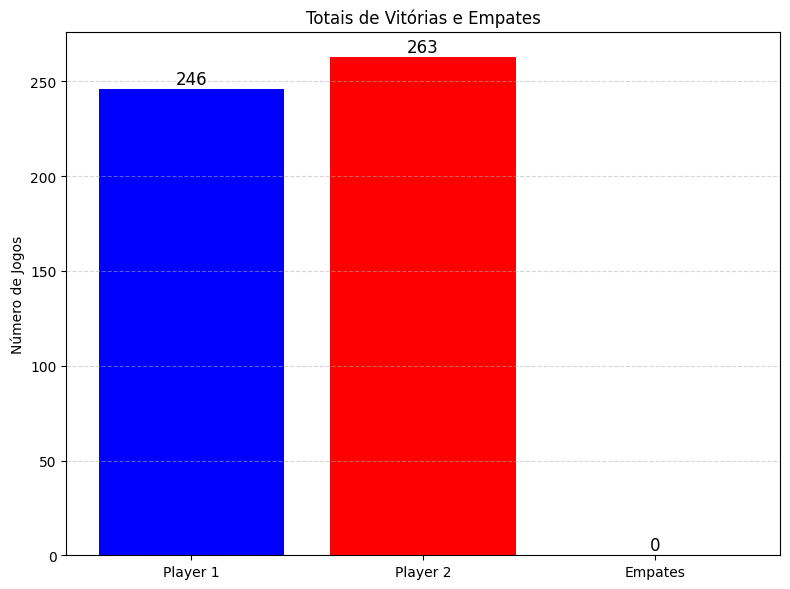


=== Elapsed time: 13 seconds ===
  Player 1: 86 victories (86.00%)
  Player 2: 14 victories (14.00%)
  Draws: 0


In [ ]:
#Decision tree with mixed data
plot_total_wins("mixed.csv")
jogo( '2',0, '1',0, 100, "mixed.csv")

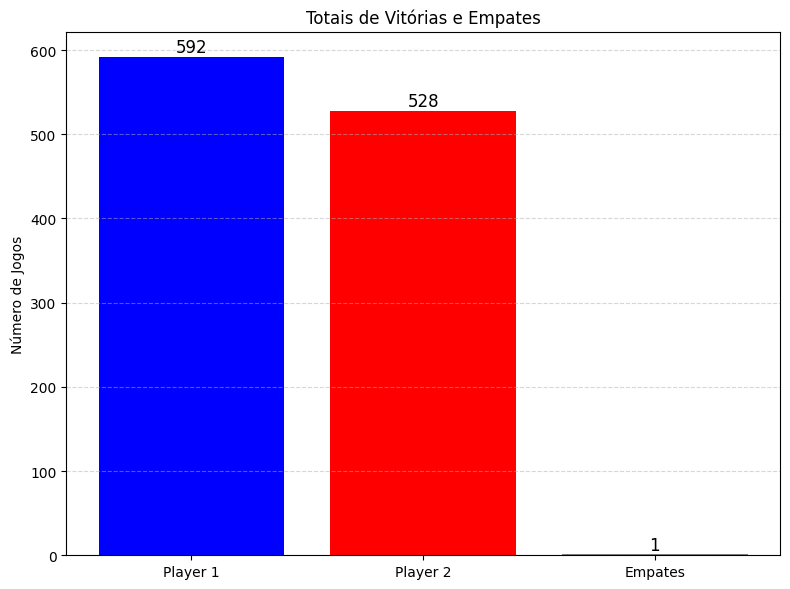


=== Elapsed time: 231 seconds ===
  Player 1: 26 victories (26.00%)
  Player 2: 74 victories (74.00%)
  Draws: 0


In [ ]:
#decision tree with very big dataset made using onlly mt carlo (pure data) vs mt carlo
plot_total_wins("big.csv")
jogo( '2',0, '3',100, 100, "big.csv")

In [60]:
#decision tree against itself, 50% win rate expected
jogo( '2',0, '2',0,100, "mixed.csv")


=== Elapsed time: 36 seconds ===
  Player 1: 0 victories (0.00%)
  Player 2: 100 victories (100.00%)
  Draws: 0


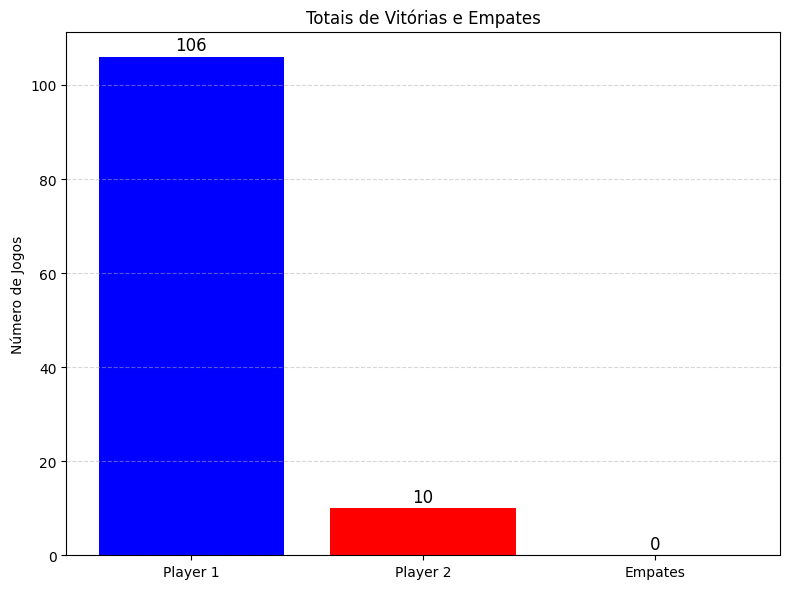


=== Elapsed time: 21 seconds ===
  Player 1: 100 victories (100.00%)
  Player 2: 0 victories (0.00%)
  Draws: 0


In [62]:
#decision tree against itself on a dataset imbalanced towards player 1
plot_total_wins("imbalanced.csv")
jogo( '2',0, '2',0,100, "imbalanced.csv")

In [65]:
#Standard Decision tree against ensemble vote, both with the same csv
jogo( '2',0, '5',0, 100,"mixed.csv")


=== Elapsed time: 38 seconds ===
  Player 1: 24 victories (24.00%)
  Player 2: 76 victories (76.00%)
  Draws: 0


In [ ]:
#Decision tree visualization
md = pd.read_csv("match_log.csv")
md = md[md['mtcarlomove'].notnull()]
md.drop_duplicates(
    subset=[f'cell_{i}' for i in range(42)] + ['player'],
    inplace=True
)


X, y = build_feature_dataset(md)

tree = ID3DecisionTree()
tree.fit(X, y, max_depth=5)

export_id3_to_dot(tree.tree, path="minha_arvore.dot")

DOT file written to: minha_arvore.dot
